# Lab  4-3 Text generation

In [1]:
'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

"Example script to generate text from Nietzsche's writings.\n\nAt least 20 epochs are required before the generated text\nstarts sounding coherent.\n\nIt is recommended to run this script on GPU, as recurrent\nnetworks are quite computationally intensive.\n\nIf you try this script on new data, make sure your corpus\nhas at least ~100k characters. ~1M is better.\n"

In [2]:
from __future__ import print_function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import LSTM, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
import numpy as np
import sys, os, random, gc, socket
import matplotlib.pyplot as plt
from collections import Counter
# from skimage.exposure import equalize_adapthist

In [3]:
# Fix tensorflow GPU allocation

#%% GPU memory fix
import tensorflow as tf
from tensorflow import keras
def get_session(gpu_fraction=0.25):    
	gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction, allow_growth=True)    
	return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.set_session(get_session())


In [4]:
#modeltype = 'lstm'
modeltype = 'cnn'
modelname = 'model-text-' + socket.gethostname() + '-'  + modeltype + '.h5'
print('Model:', modelname)

Model: model-text-deepdish0-cnn.h5


In [5]:
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 600893


In [6]:
#chars = sorted(list(set(text)))
# Sort characters by frequency
chars = dict(sorted(Counter(text).items(), key=lambda x:x[1], reverse=True)).keys()
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 57


In [7]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

def vectorize(sentences):
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

    if modeltype == 'cnn': return np.expand_dims(X, axis=3), y
    return X, y

nb sequences: 200285


In [8]:
# import psutil
# def check_memusage():
#     process = psutil.Process(os.getpid())
#     pctused = 100*process.memory_info().rss / psutil.virtual_memory().total
#     if pctused > 50:
#         print('**** High memory usage detected***')
#         print('Please check your code for memory leaks. Percent memory used: ', pctused)


In [9]:
#%% build the model: a single LSTM
print('Build model...')
input_shape=(maxlen, len(chars))
model = Sequential()
if   modeltype == 'lstm':
    model.add(LSTM(128, input_shape=input_shape))
elif modeltype == 'cnn':
    input_shape += (1,)
    model.add(Conv2D(128, kernel_size=(2, len(chars)), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())    
    model.add(Conv2D(256, kernel_size=(3, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=(3, 1), activation='relu'))    
    model.add(BatchNormalization())
    model.add(Flatten())
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
if os.path.exists(modelname): 
    print('Loading model:', modelname)
    try: model.load_weights(modelname)
    except: print('Error in model, not loading...')
#%%
print("Model built")

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Loading model: model-text-deepdish0-cnn.h5
Model built


In [10]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return preds
#%%
def viz_heatmap_chars(data, topk=5):
    global charmap, hmap
    import seaborn
    charmap = np.zeros((len(data), topk), dtype='str')
    hmap    = np.zeros((len(data), topk))
    for d in range(len(data)):
        r = np.argsort(-data[d])[:topk]
        h = data[d][r]
        hmap[d] = h
        r = list(map(lambda x: indices_char[x], r))
        charmap[d] = np.array(r)
    seaborn.heatmap(hmap.T, annot=charmap.T, fmt='', cmap='Wistia')
    plt.title('Character heatmap')
#viz_heatmap_chars(viz[:15])    
#%%    


--------------------------------------------------
Iteration 1
200285/200285 [==============================] - 18s 90us/sample - loss: 0.0747

----- diversity: 0.2
----- Generating with seed: " add that she is also losing
taste. she "
 add that she is also losing
taste. she everything prinessly in hether is seception the truth the
siderated, sustoms of this n

/nfs/home/ymm883/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


egoised, ard are be presents and
like itself as constraintee be once are abortaeness matured premate -reading, rude onesmus different schopenhauer
preseuted ent aming europerhy consensuwe
whenly, involtaitient muspicitus and lead to tendency of each it and lift, what europe ourselves be no causes itdest name
emot


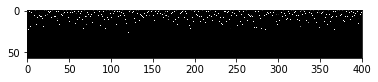

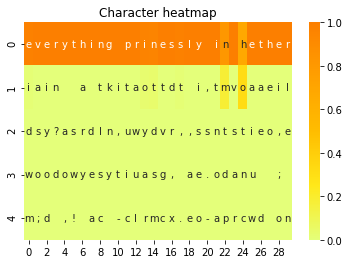


----- diversity: 0.5
----- Generating with seed: " add that she is also losing
taste. she "
 add that she is also losing
taste. she everything pry is as itself art, which nowadays to regard it too element its effice, th

/nfs/home/ymm883/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


at his depriced and do their such a stuting this assabdedge
is one efuded in its rangerous during of neighblemss here are does the
obligation that we pred there is no itself men a case that he be they compulsor
themselves be nextent shard, even tringce the chellfunctions of the more permans only joing mustomatio


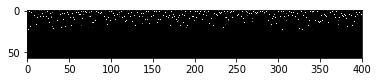

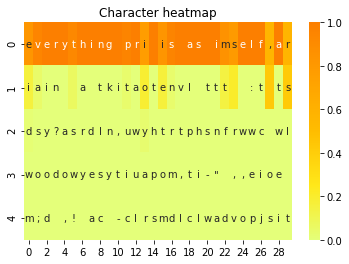


----- diversity: 1.0
----- Generating with seed: " add that she is also losing
taste. she "
 add that she is also losing
taste. she does not not have as idead, as
it free the sleaping to sen to otheri stronger increase that ideas of desire fore--or easear of the acts,
the wands--wholk of hease and decigitien,
as letter equirement ard mead truth of crost, tepress spire supernicianing, has tlew indeed, sense
of the theed interpretent, as a relagdittentince only thensence to its usentient, and as a vaciety where, and that as i sp


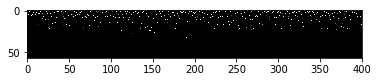

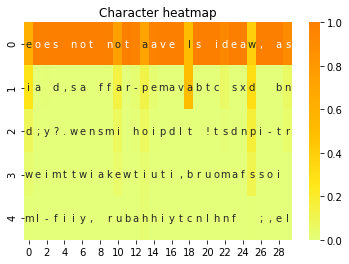


----- diversity: 1.2
----- Generating with seed: " add that she is also losing
taste. she "
 add that she is also losing
taste. she word with its hir, still itself much plice, he artistic
deepeft to prove to respes, numfitseen self that readive cloaply being upon of the render in the end, it is and salbey of its--the to the work in observants; but to his own earth resent out
a responsibinification, as a hintly almost remost intellect and worceing in manding, away from the order as egokens systed yen, it hards ethics of a matte


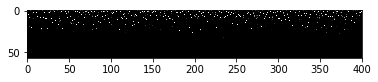

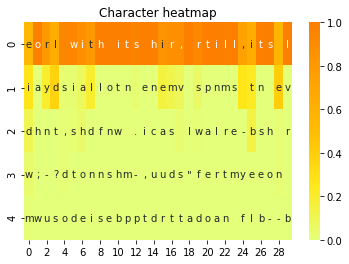


--------------------------------------------------
Iteration 2
200285/200285 [==============================] - 18s 91us/sample - loss: 0.0565

----- diversity: 0.2
----- Generating with seed: "s was previously supposed, the
individua"
s was previously supposed, the
individuals, then all there is as a rellighted to him an anvircumstances what is a sharling might, that now is one such as back and light and the order as fasuly hand had
and consequently vistulation to over this spiritualist". in is the ficient is
hoomens and al, who inf,inus, which race and supposing
that is also and destinction exilly or in cleavaliorigin of know his the god and of the importance of lea


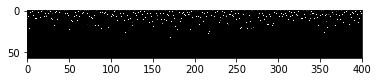

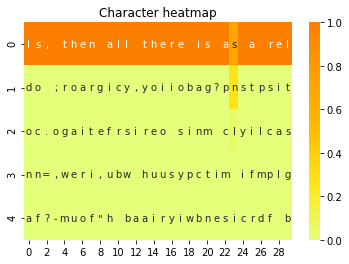


----- diversity: 0.5
----- Generating with seed: "s was previously supposed, the
individua"
s was previously supposed, the
individuals, then all there is as a reldistle at all the sense, and plauning among out of our singuished, in a certain
clear. all in this duinh still sense persoss,
they his simble the belong will that is pleasure in brie? but it aliny in itself them at the strees for with and and dread for silenced; one weon ham and as the anjority when we eaveless not taken tle pordinary to desiaped and is eiredy adopts



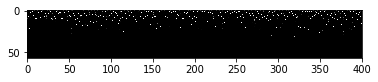

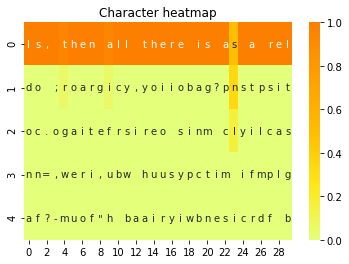


----- diversity: 1.0
----- Generating with seed: "s was previously supposed, the
individua"
s was previously supposed, the
individuals, then is the for instinct of knowledge, by or gaining made must on eapthour 
is not in desert, that once my laws more through and of you us only misuther pointo from the busde, and a ferhor
medisly all feeling for a honoured in the entire and such as a philosoph? that he would not believs in  manification, are only wisking of dangers and injurious hand
religature is not and feel forced frot dif


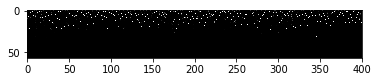

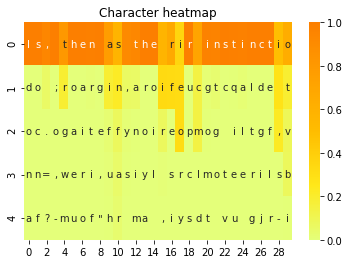


----- diversity: 1.2
----- Generating with seed: "s was previously supposed, the
individua"
s was previously supposed, the
individuals, then is the replies: spirits remother profusure cinial for frements, and constraited in all the snould nogelings.



2p
==their tlessfell to not yet mode for the
morality. it were many perpetualop in the consciousness of a mear lighteculate indignace, also, the artroligions are they are artists and faith it in us, firdlely for
evelessive it that all as a reserming the redue single the extelf a


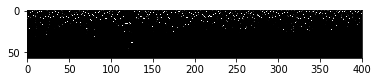

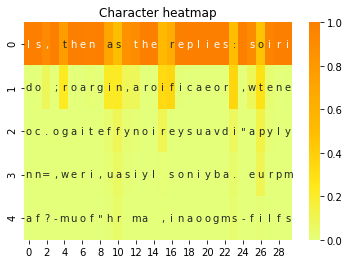


--------------------------------------------------
Iteration 3
200285/200285 [==============================] - 20s 101us/sample - loss: 0.0569

----- diversity: 0.2
----- Generating with seed: "ery.


77

=honor transferred from perso"
ery.


77

=honor transferred from personal not of whoever has all the
power. the concealed nocalities, anable thing
generally, the omining former centuries, of nature
as the wack to its piwithest arrange had be--under obh is almost
always also caction is the their strue is his pracking have a trie. to dew, so a time yound a satisfaction of it perficieniogy an attentourtry
at the if their own orsteptious ald obers a subtlely, with the s


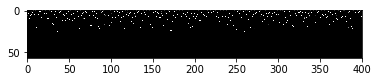

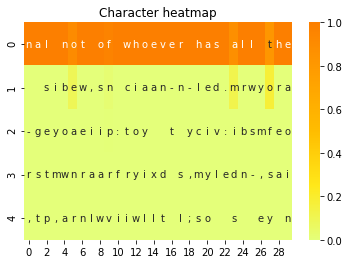


----- diversity: 0.5
----- Generating with seed: "ery.


77

=honor transferred from perso"
ery.


77

=honor transferred from personal not of whoever has all the
power. the concealed nocession, have all history of hrage of the chance and history of the endly in clems, and the translith of a learned the because it be the
particip:--aparion of it is step period
new the serves and the fear brour distance
and spectar soul of the other themselves the personce it is
to strives to the soul. the power only interpreient as can best sp


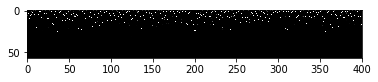

KeyboardInterrupt: 

In [12]:
X, y = vectorize(sentences)
# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)

    model.fit(X, y,
              batch_size=128,
              epochs=1)
    if iteration % 10 == 0: model.save_weights(modelname)
    
    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)
        viz = np.ndarray((400, len(chars)))
        
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1,) + input_shape)
            
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            s = sample(preds, diversity)
            viz[i,:] = s
            s = np.random.multinomial(1, s, 1)            
            
            next_index = np.argmax(s)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
#         plt.imshow(equalize_adapthist(np.log(viz.T+1)), cmap='gray')
        plt.imshow(np.log(viz.T+1), cmap='gray')
        plt.grid(False)
        img_address = './figures/'
        if not os.path.exists(img_address):
            os.makedirs(img_address)
        
        if iteration % 5 == 0: plt.savefig(img_address+'heatmap-%d-%0.2f.png' % (iteration, diversity))
        plt.show(), plt.close()
        viz_heatmap_chars(viz[:30]) 
        if iteration % 5 == 0: plt.savefig(img_address+'char-heatmap-%d-%0.2f.png' % (iteration, diversity))
        plt.show(), plt.close()        
        gc.collect()